In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
# load the wrangled table
wrangled_data = pd.read_csv('../data/processed/for_machine_learning.csv')

In [4]:
# final count of labels 0 and 1
wrangled_data.groupby('OUTPUT_LABEL')['OUTPUT_LABEL'].count()

OUTPUT_LABEL
0.0    35280
1.0     2291
Name: OUTPUT_LABEL, dtype: int64

In [5]:
# check if there are empty values
wrangled_data.isna().sum().sum()

0

In [6]:
# quick look at the columns
wrangled_data.columns

Index(['Unnamed: 0', 'OUTPUT_LABEL', '1Y_PRIOR_ADM', 'LENGTH_OF_STAY_DAYS',
       'CURR_SERVICE_MED', 'SECTIONHEADER_Evaluation and management',
       'SECTIONHEADER_Medicine', 'SUBSECTIONHEADER_Critical care services',
       'SUBSECTIONHEADER_Dialysis',
       'SUBSECTIONHEADER_Hospital inpatient services',
       'SUBSECTIONHEADER_Respiratory system',
       'Count_Alanine Aminotransferase (ALT)', 'Count_Base Excess',
       'Count_Basophils', 'Count_Creatine Kinase (CK)', 'Count_Lactate',
       'Count_Specific Gravity', 'Mean_Alanine Aminotransferase (ALT)',
       'Mean_Alkaline Phosphatase', 'Mean_Anion Gap', 'Mean_Base Excess',
       'Mean_Bicarbonate', 'Mean_Bilirubin, Total', 'Mean_Chloride',
       'Mean_Creatine Kinase (CK)', 'Mean_Creatinine', 'Mean_Eosinophils',
       'Mean_Glucose', 'Mean_Hematocrit', 'Mean_INR(PT)', 'Mean_Lactate',
       'Mean_Lymphocytes', 'Mean_MCH', 'Mean_MCHC', 'Mean_Magnesium',
       'Mean_Monocytes', 'Mean_PTT', 'Mean_Phosphate', 'Mean_Potas

In [7]:
wrangled_data.drop('Unnamed: 0', axis=1, inplace=True)
y = wrangled_data.OUTPUT_LABEL.values
X = wrangled_data.drop(['OUTPUT_LABEL'], axis=1).values
print(y.shape)
print(X.shape)

(37571,)
(37571, 94)


In [8]:
# Set a seed for reproducibility
SEED = 222
np.random.seed(SEED)

# split the data into train and test sets
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=SEED)

# scaling is necessary for some algorithms, such as SVM and neural nets, scale the data to min-max 0-1
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
Xtrain_scaled = scaler.fit_transform(Xtrain)
Xtest_scaled = scaler.transform(Xtest)

In [13]:
# import datetime
from datetime import datetime

# import a host of Scikit-learn models
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

# import ROC_AUC scoring, we will use area under the ROC curve for comparison
from sklearn.metrics import roc_curve, auc, roc_auc_score, confusion_matrix, classification_report

def get_models():
    """Generate a library of base learners."""
    nb = GaussianNB()
    svc = SVC(C=100, probability=True, class_weight='balanced')
    knn = KNeighborsClassifier(n_neighbors=3)
    lr = LogisticRegression(C=100, random_state=SEED, solver='liblinear', class_weight='balanced')
    nn = MLPClassifier((100, 50), early_stopping=True, random_state=SEED, max_iter=400, activation='tanh')
    gb = GradientBoostingClassifier(n_estimators=100, random_state=SEED)
    rf = RandomForestClassifier(n_estimators=10, max_features=3, random_state=SEED, class_weight='balanced')

    models = {'svm': svc,
              'knn': knn,
              'naive bayes': nb,
              'mlp-nn': nn,
              'random forest': rf,
              'gbm': gb,
              'logistic': lr,
              }

    return models


def train_predict(model_list, xtrain, ytrain, xtest):
    """Fit models in list on training set and return preds"""
    P = np.zeros((ytest.shape[0], len(model_list)))
    P = pd.DataFrame(P)

    print("Fitting models.")
    cols = list()
    for i, (name, m) in enumerate(models.items()):
        current_time = datetime.now() 
        print("%s..." % name, end=" ", flush=False)
        m.fit(xtrain, ytrain)
        P.iloc[:, i] = m.predict_proba(xtest)[:, 1]
        cols.append(name)
        time_elapsed = datetime.now() - current_time
        print("Time elapsed ", time_elapsed)
        print("done")

    P.columns = cols
    print("Done.\n")
    return P


def score_models(P, y):
    """Score model in prediction DF"""
    print("Scoring models.")
    for m in P.columns:
        score = roc_auc_score(y, P.loc[:, m])
        print("%-26s: %.3f" % (m, score))
    print("Done.\n")

In [14]:
models = get_models()
P = train_predict(models, Xtrain_scaled, ytrain, Xtest_scaled)
score_models(P, ytest)

Fitting models.
svm... Time elapsed  0:20:19.073042
done
knn... Time elapsed  0:00:24.402219
done
naive bayes... Time elapsed  0:00:00.071567
done
mlp-nn... Time elapsed  0:00:02.838126
done
random forest... Time elapsed  0:00:00.442235
done
gbm... Time elapsed  0:09:40.286258
done
logistic... Time elapsed  0:00:03.834713
done
Done.

Scoring models.
svm                       : 0.606
knn                       : 0.566
naive bayes               : 0.684
mlp-nn                    : 0.685
random forest             : 0.587
gbm                       : 0.708
logistic                  : 0.715
Done.



In [9]:
#import warnings
#warnings.filterwarnings("ignore")
import time
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report

start_time = time.monotonic()
clf = LogisticRegression(solver='liblinear', random_state=SEED, class_weight='balanced', max_iter=200)
clf.fit(Xtrain,ytrain)
ypred = clf.predict(Xtest)
print(confusion_matrix(ytest, ypred))
print(classification_report(ytest, ypred))
print(time.monotonic()-start_time)
start_time = time.monotonic()

[[4860 2195]
 [ 172  288]]
              precision    recall  f1-score   support

         0.0       0.97      0.69      0.80      7055
         1.0       0.12      0.63      0.20       460

    accuracy                           0.69      7515
   macro avg       0.54      0.66      0.50      7515
weighted avg       0.91      0.69      0.77      7515

28.199261839999963


In [12]:
from sklearn.metrics import roc_curve, auc, roc_auc_score, confusion_matrix, classification_report

def score_models(P, y):
    """Score model in prediction DF"""
    print("Scoring models.")
    for m in P.columns:
        score = roc_auc_score(y, P.loc[:, m])
        print("%-26s: %.3f" % (m, score))
    print("Done.\n")

start_time = time.monotonic()

Cs = np.logspace(-4, 4, 9)
PL = np.zeros((ytest.shape[0], len(Cs)))
PL = pd.DataFrame(PL)


Cs = np.logspace(-4, 4, 9)
ave_train_scores=[]
test_scores=[]

logreg_models = {}
cols = list()
for i in range(len(Cs)):
    clf = LogisticRegression(C=Cs[i], random_state=SEED, solver='liblinear', class_weight='balanced')
    clf.fit(Xtrain_scaled, ytrain)
    PL.iloc[:, i] = clf.predict_proba(Xtest_scaled)[:, 1]
    cols.append(Cs[i])
    logreg_models[Cs[i]] = clf

PL.columns = cols
score_models(PL, ytest) 

Scoring models.
0.0001                    : 0.663
0.001                     : 0.680
0.01                      : 0.699
0.1                       : 0.710
1.0                       : 0.714
10.0                      : 0.715
100.0                     : 0.715
1000.0                    : 0.715
10000.0                   : 0.715
Done.



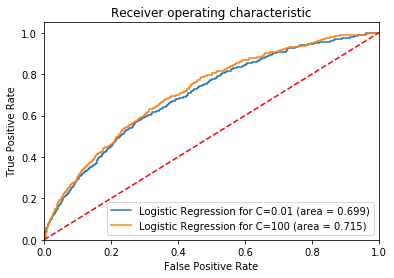

In [15]:
logit_roc_auc_001 = roc_auc_score(ytest, PL[0.01])
logit_roc_auc_100 = roc_auc_score(ytest, PL[100])

fpr_001, tpr_001, _001 = roc_curve(ytest, PL[0.01])
fpr_100, tpr_100, _100 = roc_curve(ytest, PL[100])
plt.figure()
plt.plot(fpr_001, tpr_001, label='Logistic Regression for C=0.01 (area = %0.3f)' % logit_roc_auc_001)
plt.plot(fpr_100, tpr_100, label='Logistic Regression for C=100 (area = %0.3f)' % logit_roc_auc_100)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [17]:
start_time = time.monotonic()
clf = LogisticRegression(penalty='l1', C=100, solver='liblinear', random_state=SEED, class_weight='balanced', max_iter=200)
clf.fit(Xtrain,ytrain)
ypred = clf.predict(Xtest)
print(confusion_matrix(ytest, ypred))
print(classification_report(ytest, ypred))
print(time.monotonic()-start_time)
start_time = time.monotonic()

[[4848 2207]
 [ 174  286]]
              precision    recall  f1-score   support

         0.0       0.97      0.69      0.80      7055
         1.0       0.11      0.62      0.19       460

    accuracy                           0.68      7515
   macro avg       0.54      0.65      0.50      7515
weighted avg       0.91      0.68      0.77      7515

10.78173574199991
